In [ ]:
!pip3 install pmdarima
!pip3 install seaborn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from pmdarima.arima import auto_arima
import multiprocessing as mp

sns.set(rc={'figure.figsize':(11.7,8.27)})

## Reading the datasets

df1 = pd.read_csv("data/BATADAL_dataset03.csv")
df2 = pd.read_csv("data/BATADAL_dataset04.csv")
df2.columns = df2.columns.str.replace(" ", "")
dftest = pd.read_csv("data/BATADAL_test_dataset.csv")

In [4]:
## Add the right attack flags
new_attack_df2 = df2[['DATETIME', 'ATT_FLAG']].copy()
new_attack_df2['ATT_FLAG'] = 0

attack_points = [
    ["13/09/2016 23", "16/09/2016 00"],
    ["26/09/2016 11", "27/09/2016 10"],
    ["09/10/2016 09", "11/10/2016 20"],
    ["29/10/2016 19", "02/11/2016 16"],
    ["26/11/2016 17", "29/11/2016 04"],
    ["06/12/2016 07", "10/12/2016 04"],
    ["14/12/2016 15", "19/12/2016 04"]
]

for attack_point in attack_points:
    new_attack_df2.loc[attack_point[0]:attack_point[1], 'ATT_FLAG'] = 1
    

new_attack_df_test = dftest[['DATETIME']].copy().set_index("DATETIME")
new_attack_df_test['ATT_FLAG'] = 0

attack_points = [
    ["16/01/17 09", "19/01/17 06"],
    ["30/01/17 08", "02/02/17 00"],
    ["09/02/17 03", "10/02/17 09"],
    ["12/02/17 01", "13/02/17 07"],
    ["24/02/17 05", "28/02/17 08"],
    ["10/03/17 14", "13/03/17 21"],
    ["25/03/17 20", "27/03/17 01"]
]

for attack_point in attack_points:
    new_attack_df_test.loc[attack_point[0]:attack_point[1], 'ATT_FLAG'] = 1
    
new_attack_df_test.reset_index(inplace=True)

NameError: name 'new_attack_df' is not defined

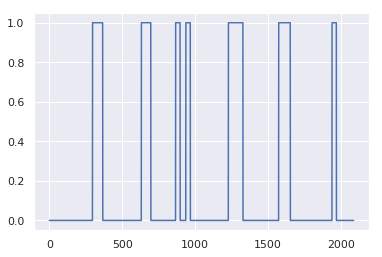

In [3]:
sns.lineplot(data=new_attack_df_test.reset_index()['ATT_FLAG'])

In [ ]:
new_attack_df_test

In [10]:
## Trying to fit ARMA models on the training data

target_sensors = df1.columns.tolist()
target_sensors.remove("DATETIME")
target_sensors.remove("ATT_FLAG")
models = []

def get_arima(sensor, series):
    print("Currently trying to fit " + sensor)
    stepwise_fit = auto_arima(series, start_p=1, start_q=1, max_p=50, max_q=50,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise
    return (sensor, stepwise_fit)

pool = mp.Pool(processes=4)
models = [pool.apply_async(get_arima, args=(sensor, df1[sensor].values.copy(),)) for sensor in target_sensors]
pool.close()  # do not accept any more tasks
pool.join()  # wait for the completion of all scheduled jobs

Currently trying to fit L_T1
Currently trying to fit L_T3
Currently trying to fit L_T2
Currently trying to fit L_T4
Currently trying to fit L_T5
Currently trying to fit L_T6
Currently trying to fit L_T7
Currently trying to fit F_PU1
Currently trying to fit S_PU1


/usr/local/lib/python3.7/dist-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Currently trying to fit F_PU2
Currently trying to fit S_PU2
Currently trying to fit F_PU3


/usr/local/lib/python3.7/dist-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Currently trying to fit S_PU3


/usr/local/lib/python3.7/dist-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Currently trying to fit F_PU4
Currently trying to fit S_PU4
Currently trying to fit F_PU5


/usr/local/lib/python3.7/dist-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Currently trying to fit S_PU5


/usr/local/lib/python3.7/dist-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Currently trying to fit F_PU6
Currently trying to fit S_PU6
Currently trying to fit F_PU7
Currently trying to fit S_PU7
Currently trying to fit F_PU8
Currently trying to fit S_PU8
Currently trying to fit F_PU9


/usr/local/lib/python3.7/dist-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Currently trying to fit S_PU9


/usr/local/lib/python3.7/dist-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Currently trying to fit F_PU10
Currently trying to fit S_PU10
Currently trying to fit F_PU11
Currently trying to fit S_PU11
Currently trying to fit F_V2
Currently trying to fit S_V2
Currently trying to fit P_J280
Currently trying to fit P_J269
Currently trying to fit P_J300
Currently trying to fit P_J256
Currently trying to fit P_J289
Currently trying to fit P_J415
Currently trying to fit P_J302
Currently trying to fit P_J306
Currently trying to fit P_J307
Currently trying to fit P_J317
Currently trying to fit P_J14
Currently trying to fit P_J422


In [11]:
## Saving these models
import pickle 

models_to_write = [model.get() for model in models]
filename = "ARMA_models.obj"
file_to_write = open(filename, 'wb')
pickle.dump(models_to_write, file_to_write)

In [12]:
## Load again and check the best fits

file_to_read = open(filename, 'rb')
models_read = pickle.load(file_to_read)

In [73]:
aic_models = pd.DataFrame(columns=['AIC', 'order'])
for model in models_read:
    aic_models.loc[model[0], :]= np.array([model[1].aic(), model[1].order])

aic_models.sort_values(by='AIC')

,AIC,order
S_PU1,-540384,"(0, 0, 0)"
P_J280,-78191.2,"(4, 0, 6)"
S_PU11,-48586.6,"(0, 0, 1)"
S_PU6,-34533.1,"(0, 0, 2)"
L_T1,-13301.2,"(2, 0, 3)"
L_T6,-12699,"(7, 0, 3)"
L_T3,-7863.57,"(2, 0, 4)"
S_PU2,-4219.97,"(2, 0, 8)"
L_T2,-1101.28,"(4, 0, 3)"
L_T5,-689.113,"(5, 0, 5)"


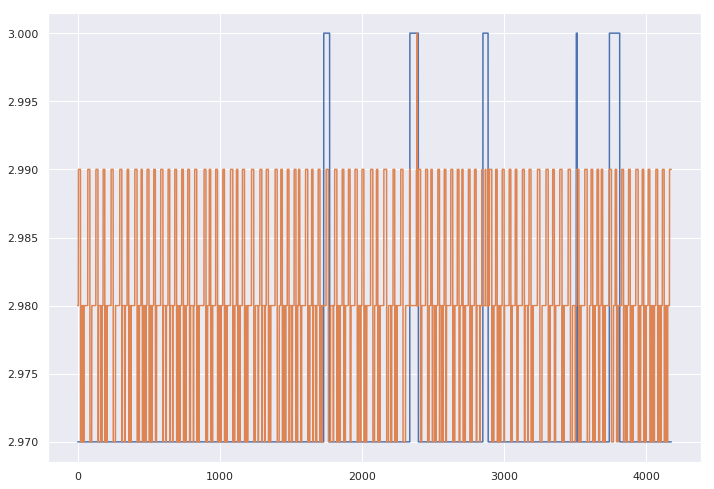

In [74]:
fig, ax = plt.subplots()
target = 'P_J280'
attack = df2['ATT_FLAG'].copy()
attack[attack > 0] = max(df2[target])
attack[attack <= 0] = min(df2[target])
sns.lineplot(data=attack,ax=ax)
sns.lineplot(data=df2[target],ax=ax)


In [76]:
target_columns = ['F_PU6', 'S_PU6', 'F_PU11', 'S_PU11', 'F_PU7', 'S_PU7', 'L_T1', 'P_J14', 'P_J302', 'P_J307']


In [80]:
aic_models.loc[target_columns, :]

,AIC,order
F_PU6,28583.9,"(0, 0, 2)"
S_PU6,-34533.1,"(0, 0, 2)"
F_PU11,7079.51,"(0, 0, 1)"
S_PU11,-48586.6,"(0, 0, 1)"
F_PU7,74440.2,"(1, 0, 2)"
S_PU7,6101.2,"(1, 0, 2)"
L_T1,-13301.2,"(2, 0, 3)"
P_J14,41858.4,"(1, 0, 1)"
P_J302,45169,"(5, 0, 5)"
P_J307,45296,"(5, 0, 5)"


In [85]:
current_model = None
target = 'L_T1'
for model in models_read:
    if model[0] == target:
        current_model = model
        break

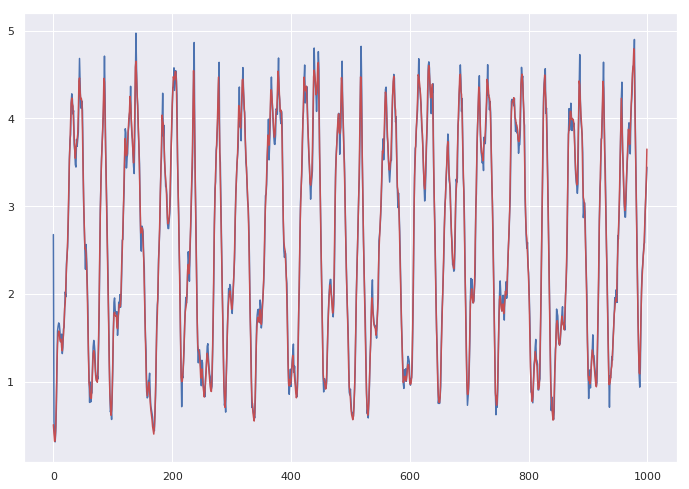

In [88]:
## Show example predictions

predictions = current_model[1].predict_in_sample()
true_data = df1[target]

fig, ax = plt.subplots()
sns.lineplot(data=predictions[0:1000], ax=ax, color='b')
sns.lineplot(data=true_data[0:1000], ax=ax, color='r')

In [141]:
## Set a threshold for anomalies and see if there are any

min_diff = min(abs(predictions - true_data))
max_diff = max(abs(predictions - true_data))
max_diff =0.5
steps = 50

ranges = np.arange(min_diff,max_diff, (max_diff-min_diff)/steps)
rates = pd.DataFrame([], index=ranges, columns=["True Positive",'False Negative'])


for threshold in ranges:
    rates.loc[threshold, 'True Positive'] = (df2.loc[abs(predictions - true_data) > threshold, ['ATT_FLAG']] == 1).sum()[0]
    rates.loc[threshold, 'False Negative'] = (df2.loc[abs(predictions - true_data) > threshold, ['ATT_FLAG']] == -999).sum()[0]
    
recall = rates['True Positive'] /  rates['True Positive'].max()
precision = rates['True Positive'] /  (rates['True Positive'] + rates['False Negative'])


[Text(0.5, 0, 'Threshold')]

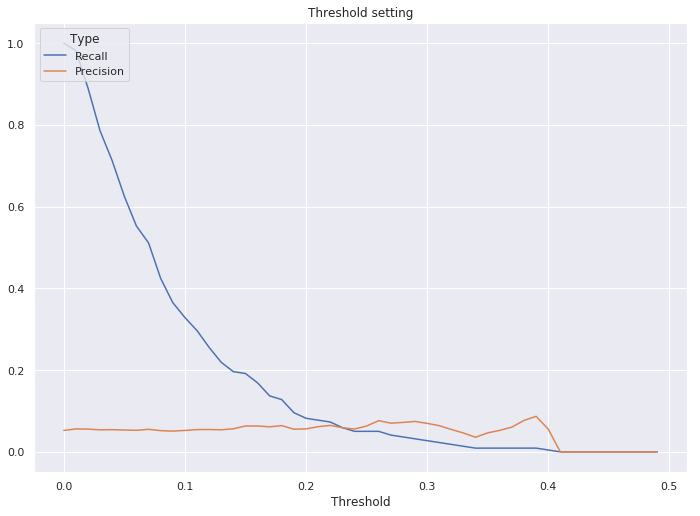

In [150]:
fig, ax = plt.subplots()
sns.lineplot(data=recall, ax=ax)
sns.lineplot(data=precision, ax=ax)
ax.legend(title='Type', loc='upper left', labels=['Recall', 'Precision'])
ax.legend(title='Type', loc='upper left', labels=['Recall', 'Precision'])
ax.set(title="Threshold setting")
ax.set(xlabel='Threshold')